In [1]:
import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import BatchNorm1d
from torch.nn.modules.conv import Conv2d
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST


from tqdm import tqdm
from time import sleep

In [2]:
torch.__version__

'1.11.0+cu113'

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the dataset: the anomaly digit: 0


np.random.seed(0)

labels = np.array([0,1,2,3,4,5,6,7,8,9])
anomaly_id = 0

normal_labels = np.delete(labels,anomaly_id) # normal labels

dataset = torchvision.datasets.MNIST(root = '', train=False, transform=transforms.ToTensor(), download=True)
x = dataset.data.detach().numpy()
y = dataset.targets.detach().numpy()

# Scale pixels in [0,1]
#x = (x/255 - 0.5)*2 #[-1,1]
x = x/255


M = x.shape[0]
random_idx_ord = np.random.permutation(M)
train_indices = random_idx_ord[0: int(0.8 * M)]
test_indices = random_idx_ord[int(0.8 * M): ]
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

idx = np.argsort(y_train)

abnormal_indecies = np.where(y_train == anomaly_id)[0]

x_train_abnormal = x_train[abnormal_indecies]
y_train_abnormal = y_train[abnormal_indecies]

x_train_normal = np.delete(x_train, abnormal_indecies,axis = 0)
y_train_normal = np.delete(y_train, abnormal_indecies)


train_tensor_x = torch.Tensor(x_train_normal) # transform to torch tensor
train_tensor_y = torch.Tensor(y_train_normal)

test_tensor_x = torch.Tensor(x_test) # transform to torch tensor
test_tensor_y = torch.Tensor(y_test)

train_dataset = TensorDataset(train_tensor_x,train_tensor_y) 
train_loader = DataLoader(train_dataset,batch_size=64, shuffle=True) 

test_dataset = TensorDataset(test_tensor_x,test_tensor_y) 
test_loader = DataLoader(test_dataset,batch_size=1, shuffle=False,drop_last=True ) 


In [3]:
test_idx = np.argsort(y_test)

test_abnormal_indecies = np.where(y_test == anomaly_id)[0]

x_test_abnormal = x_test[test_abnormal_indecies]
y_test_abnormal = y_test[test_abnormal_indecies]

In [4]:
y_test_abnormal.size


191

In [7]:
y_test_abnormal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
x_train_normal[2].shape

(28, 28)

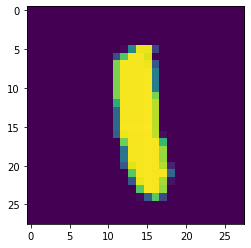

In [8]:

img = x_train_normal[2]
plt.imshow(img)
#plt.title('true_label:' +str(y[idx]))
plt.show()


### BiGAN

In [5]:
class Discriminator(nn.Module):
    """
A dense neural network
    """
    def __init__(self,
                 input_dim = 28 * 28,
                 latent_dim = 50,
                 hidden_neurons = [1024, 1024],
                 output_dim = 1

                 ):
        super(Discriminator, self).__init__()
        # self.realnets = nn.Sequential(
        #     nn.Conv2d(1,64,(4,4),(2,2)), # output size: 13 #kernel size odd is better--chessboard, except the last 
        #     nn.LeakyReLU(0.1),
        #     nn.Conv2d(64,64,(4,4),(2,2)), # output size: 5
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(0.1)
        # )
        
        # self.fakenets = nn.Sequential(
        #     nn.Linear(200,512),
        #     nn.LeakyReLU(0.1)
        # )
        # self.nets = nn.Sequential(
        #     nn.Linear(512 + 5 * 5 * 64,1024),
        #     nn.LeakyReLU(0.1),
        #     nn.Linear(1024,1),
        #     nn.Sigmoid()
        # )
        self.nets = nn.Sequential(
            nn.Linear(input_dim + latent_dim, hidden_neurons[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_neurons[0], hidden_neurons[1]),
            nn.BatchNorm1d(hidden_neurons[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_neurons[1],output_dim,bias = False),
            nn.Sigmoid()
        )
        
        

    def forward(self, x, z):
        # x = x.view(x.shape[0],1,28,28)
        # D_x = self.realnets(x)
        # D_x = torch.flatten(D_x,1)
        # D_z = self.fakenets(z)
        #print(D_x.shape,D_z.shape)
        jointxz = torch.cat([x, z], dim=1)
        
        output = self.nets(jointxz)
        return output

In [6]:

class Generator(nn.Module):
    """
    z -> x'
    """
    def __init__(self,
                 input_dim = 50,
                 output_dim = 28 * 28,
                 hidden_neurons = [1024,1024]
                 ):
        super(Generator, self).__init__()
        # self.nets = nn.Sequential(
        #     nn.Linear(200, 1024),
        #     nn.BatchNorm1d(1024),
        #     nn.ReLU(),
        #     nn.Linear(1024, 5 * 5 * 128))

        # self.nets1 = nn.Sequential(
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d( 128, 64, 5,2),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64,1,4,2),
        #     nn.Tanh()
        # )
        self.nets = nn.Sequential(
            nn.Linear(input_dim, hidden_neurons[0]),
            nn.ReLU(),
            nn.Linear(hidden_neurons[0], hidden_neurons[1]),
            nn.BatchNorm1d(hidden_neurons[1]),
            nn.ReLU(),
            nn.Linear(hidden_neurons[1], output_dim,bias = False),
            nn.Sigmoid()
        )
    def forward(self, z):
        x_hat = self.nets(z)
        #print(x_hat.shape)
        # x_hat = x_hat.view(x_hat.shape[0],128,5,5)
        
        # #print(x_hat.shape)
        # x_hat = self.nets1(x_hat)
        #print(x_hat.shape)
        return x_hat

In [7]:

class Encoder(nn.Module):
    """
    x -> z'
    """
    def __init__(self,
                 input_dim = 28 * 28,
                 output_dim = 50,
                 hidden_neurons = [1024,1024]
                 ):
        super(Encoder, self).__init__()
        # self.nets = nn.Sequential(
        #     nn.Conv2d(1,32,(3,3),(1,1)), # Output size: 26
            
        #     nn.Conv2d(32,64,(3,3),(2,2)), # Output size: 12
        #     nn.BatchNorm2d(64),
        #     nn.LeakyReLU(0.1),
        #     nn.Conv2d(64,128,(3,3),(2,2)), # Output size: 5
            
        #     nn.BatchNorm2d(128), 
        #     nn.LeakyReLU(0.1)
        # )
        # self.fc = nn.Linear(128 * 5 * 5, 200)
        self.nets = nn.Sequential(
            nn.Linear(input_dim, hidden_neurons[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_neurons[0], hidden_neurons[1]),
            nn.BatchNorm1d(hidden_neurons[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_neurons[1], output_dim,bias = False)
        )
        
    def forward(self, x):
        # z_hat = x.view(x.shape[0],1,28,28)
        # z_hat = self.nets(z_hat)
        # #print(z_hat.shape)
        # z_hat = torch.flatten(z_hat,1)
        # z_hat = self.fc(z_hat)
        #print(z_hat.shape)
        z_hat = self.nets(x)
        return z_hat

In [8]:
# Weight, bias initialization
def init_weights(Layer):
    name = Layer.__class__.__name__
    if name == 'Linear':
        torch.nn.init.normal_(Layer.weight, mean=0, std=0.02)
        if Layer.bias is not None:
            torch.nn.init.constant_(Layer.bias, 0)

In [9]:
def D_loss(DG, DE, eps=1e-6):
    loss = torch.log(DE + eps) + torch.log(1 - DG + eps)
    return -torch.mean(loss)

In [10]:
def EG_loss(DG, DE, eps=1e-6):
    loss = torch.log(DG + eps) + torch.log(1 - DE + eps)
    return -torch.mean(loss)

Epoch 10: 100%|██████████| 113/113 [00:01<00:00, 58.78batch/s, avg_D_loss=1.24, avg_EG_loss=1.57]


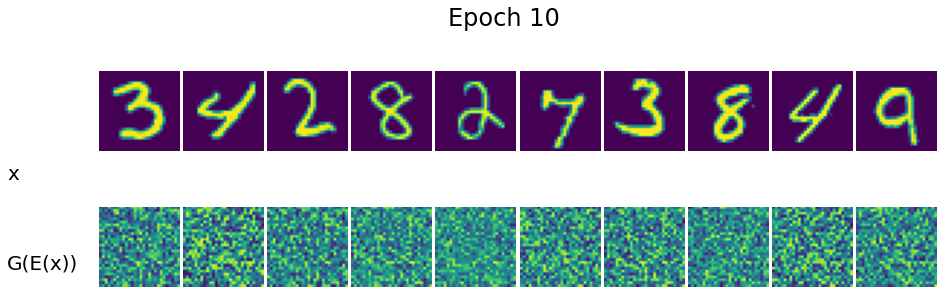

Epoch 20: 100%|██████████| 113/113 [00:02<00:00, 51.69batch/s, avg_D_loss=0.948, avg_EG_loss=2.07]


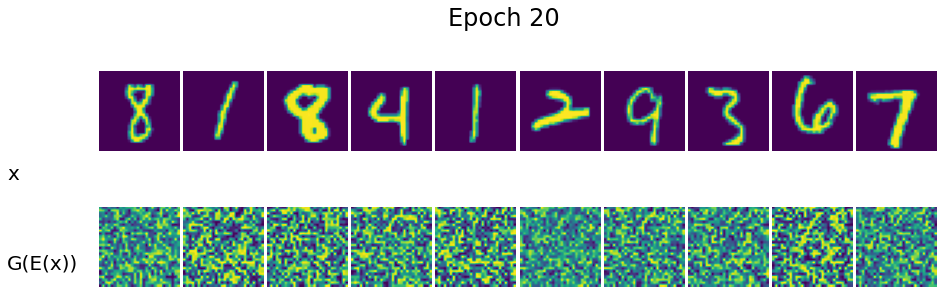

Epoch 30: 100%|██████████| 113/113 [00:02<00:00, 53.99batch/s, avg_D_loss=0.688, avg_EG_loss=2.71]


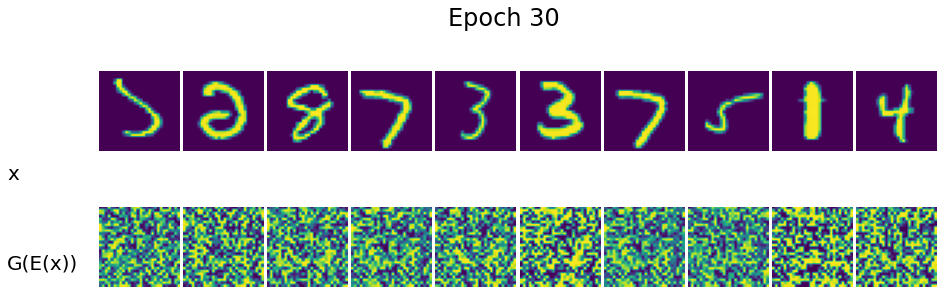

Epoch 40: 100%|██████████| 113/113 [00:02<00:00, 55.98batch/s, avg_D_loss=0.612, avg_EG_loss=2.94]


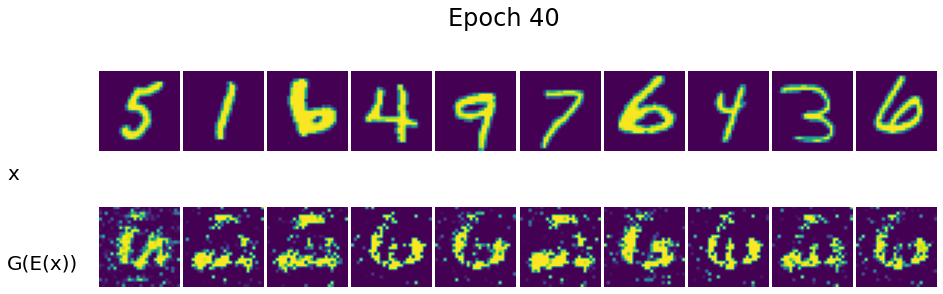

Epoch 50: 100%|██████████| 113/113 [00:02<00:00, 50.74batch/s, avg_D_loss=0.47, avg_EG_loss=3.47]


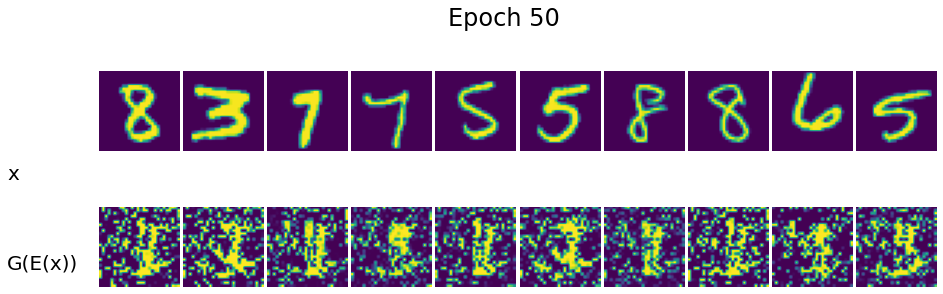

Epoch 60: 100%|██████████| 113/113 [00:02<00:00, 50.69batch/s, avg_D_loss=0.35, avg_EG_loss=4.09]


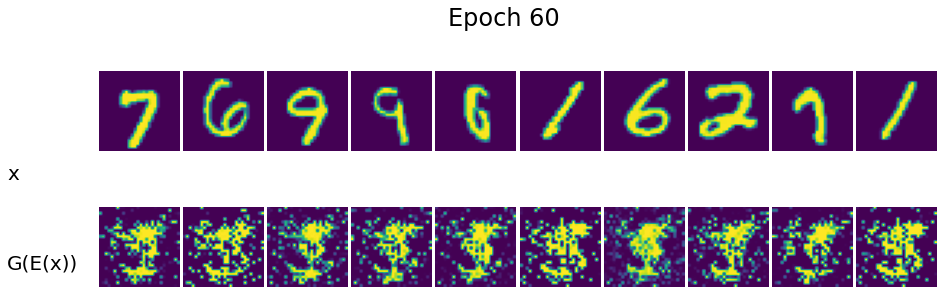

Epoch 70: 100%|██████████| 113/113 [00:02<00:00, 53.15batch/s, avg_D_loss=0.276, avg_EG_loss=4.61]


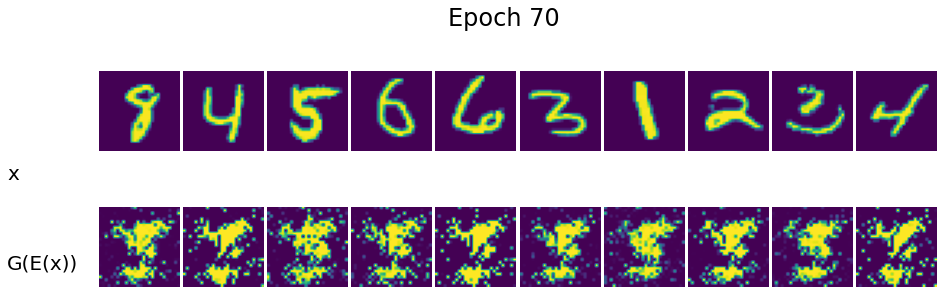

Epoch 80: 100%|██████████| 113/113 [00:02<00:00, 54.27batch/s, avg_D_loss=0.236, avg_EG_loss=5.03]


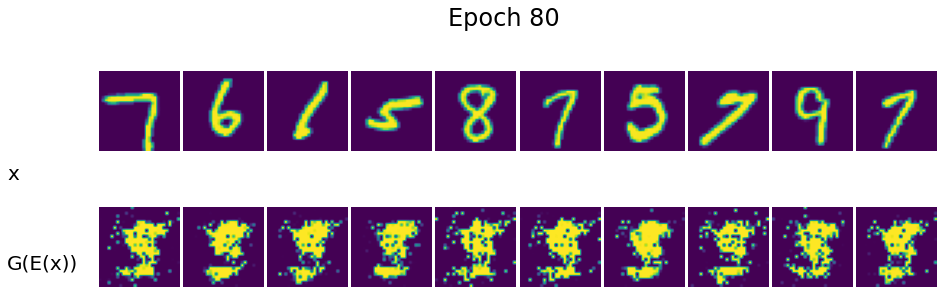

Epoch 90: 100%|██████████| 113/113 [00:02<00:00, 51.98batch/s, avg_D_loss=0.195, avg_EG_loss=5.5]


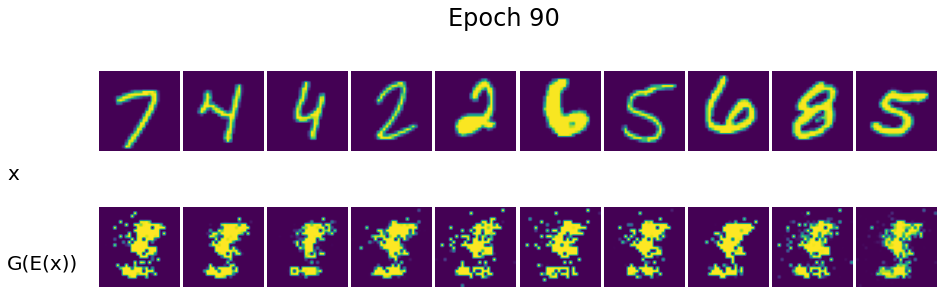

Epoch 100: 100%|██████████| 113/113 [00:02<00:00, 56.39batch/s, avg_D_loss=0.158, avg_EG_loss=5.96]


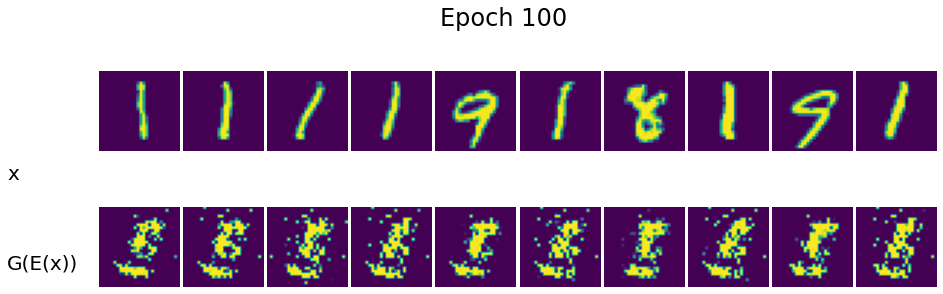

Epoch 110: 100%|██████████| 113/113 [00:02<00:00, 51.77batch/s, avg_D_loss=0.137, avg_EG_loss=6.33]


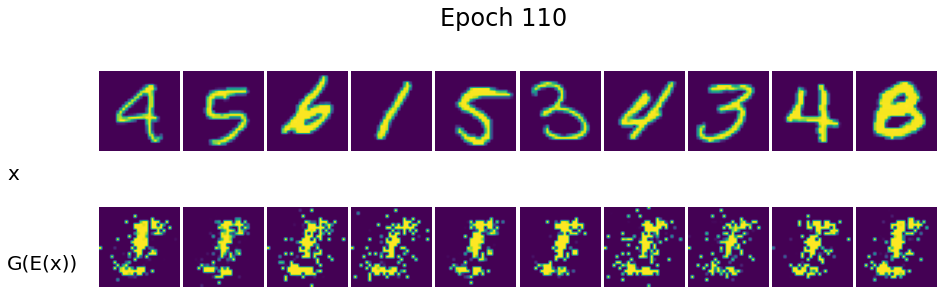

Epoch 120: 100%|██████████| 113/113 [00:02<00:00, 55.74batch/s, avg_D_loss=0.118, avg_EG_loss=6.67]


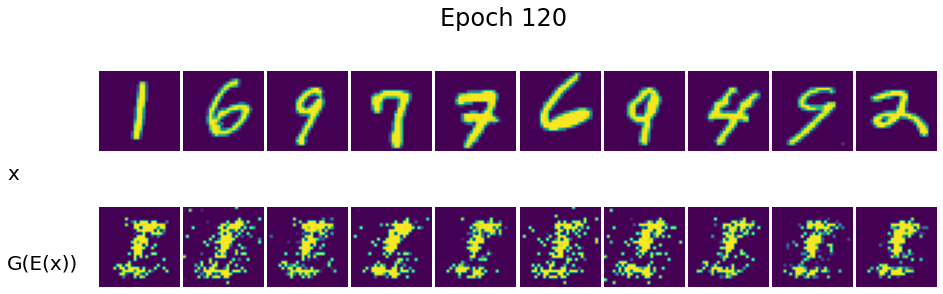

Epoch 130: 100%|██████████| 113/113 [00:02<00:00, 51.01batch/s, avg_D_loss=0.102, avg_EG_loss=7.04]


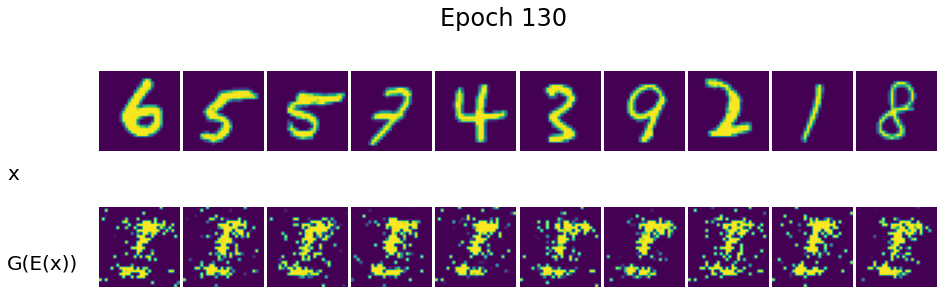

Epoch 140: 100%|██████████| 113/113 [00:02<00:00, 50.82batch/s, avg_D_loss=0.103, avg_EG_loss=7.17]


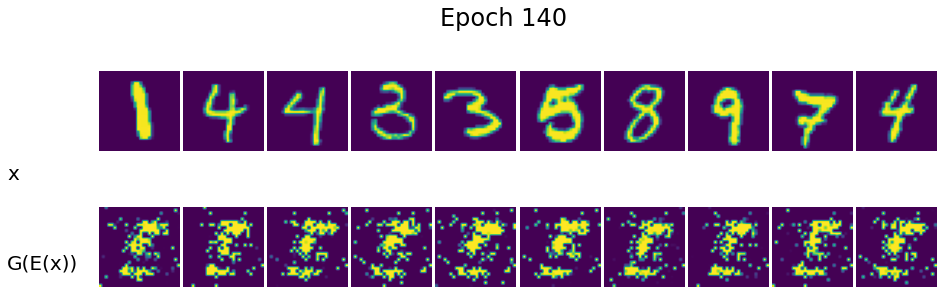

Epoch 150: 100%|██████████| 113/113 [00:02<00:00, 56.45batch/s, avg_D_loss=0.0852, avg_EG_loss=7.46]


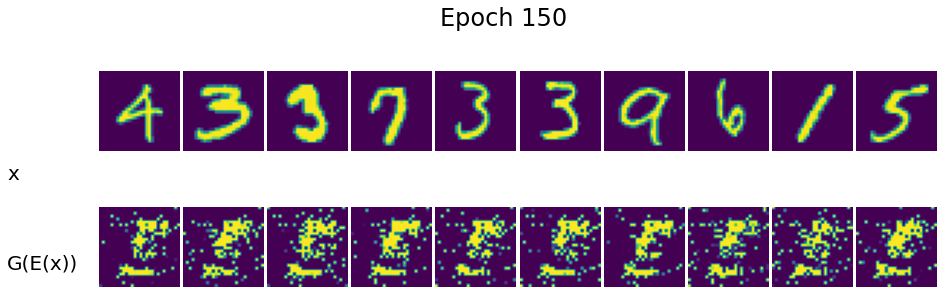

Epoch 160: 100%|██████████| 113/113 [00:02<00:00, 50.06batch/s, avg_D_loss=0.0808, avg_EG_loss=7.72]


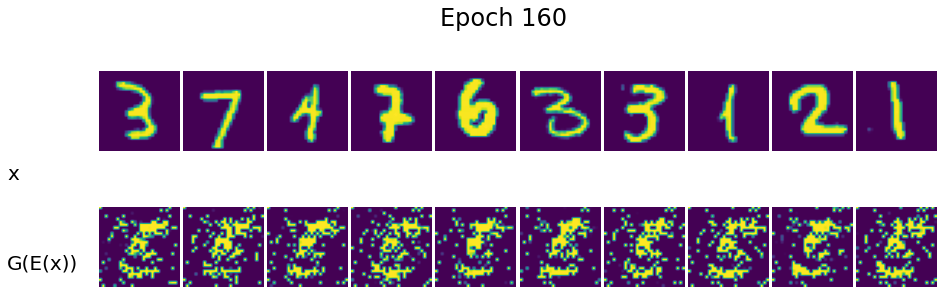

Epoch 170: 100%|██████████| 113/113 [00:02<00:00, 53.72batch/s, avg_D_loss=0.0732, avg_EG_loss=8.03]


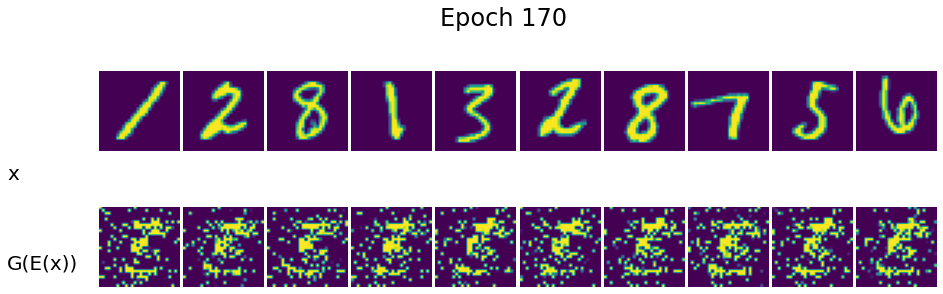

Epoch 180: 100%|██████████| 113/113 [00:01<00:00, 57.70batch/s, avg_D_loss=0.0707, avg_EG_loss=8.31]


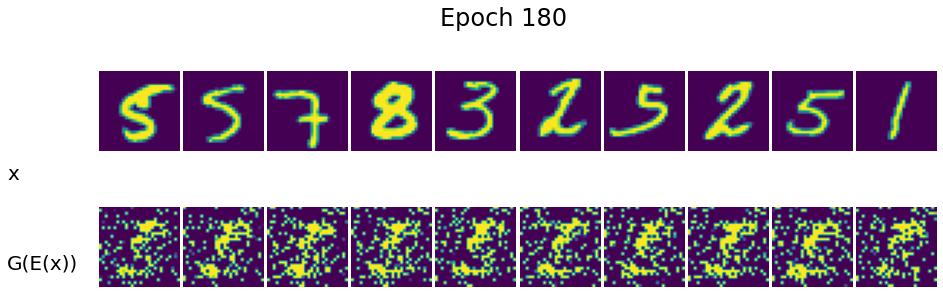

Epoch 190: 100%|██████████| 113/113 [00:02<00:00, 52.89batch/s, avg_D_loss=0.0687, avg_EG_loss=8.39]


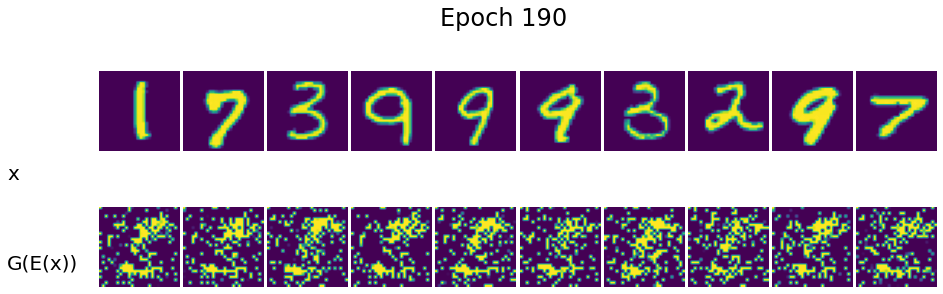

Epoch 200: 100%|██████████| 113/113 [00:02<00:00, 53.25batch/s, avg_D_loss=0.0568, avg_EG_loss=8.49]


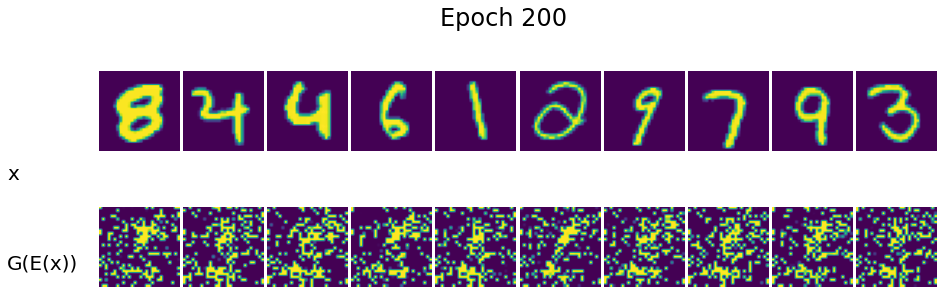

Epoch 210: 100%|██████████| 113/113 [00:02<00:00, 53.80batch/s, avg_D_loss=0.0633, avg_EG_loss=8.79]


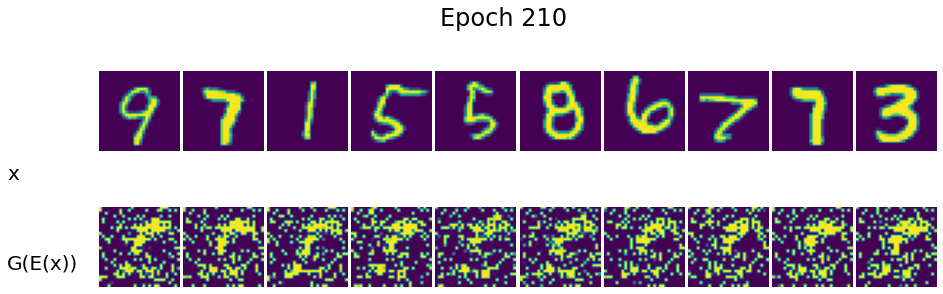

Epoch 220: 100%|██████████| 113/113 [00:02<00:00, 50.86batch/s, avg_D_loss=0.0859, avg_EG_loss=8.94]


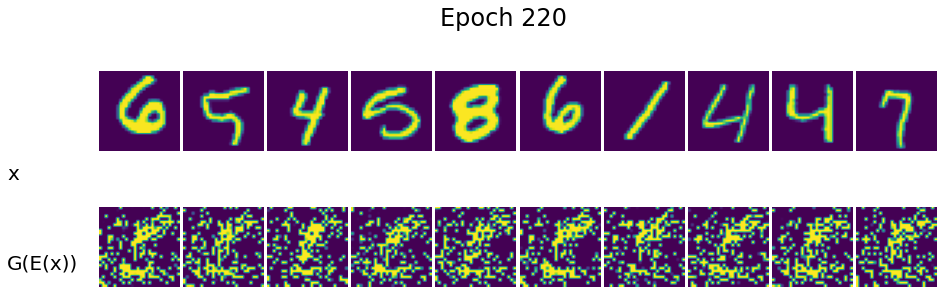

Epoch 230: 100%|██████████| 113/113 [00:02<00:00, 54.13batch/s, avg_D_loss=0.0541, avg_EG_loss=9.22]


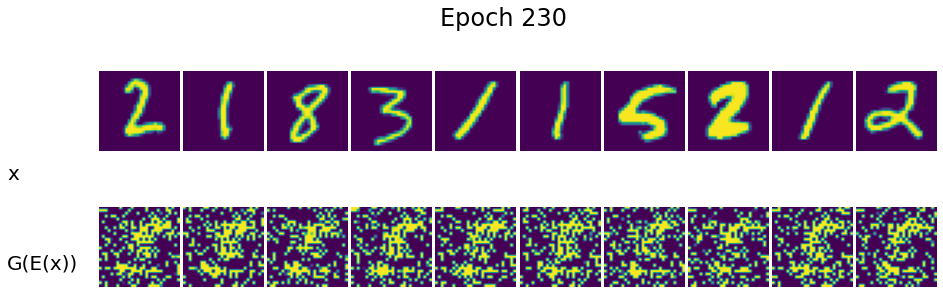

Epoch 240: 100%|██████████| 113/113 [00:02<00:00, 55.05batch/s, avg_D_loss=0.0611, avg_EG_loss=9.21]


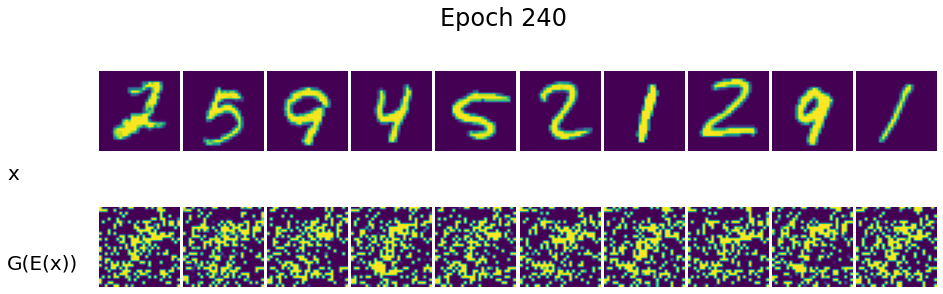

Epoch 250: 100%|██████████| 113/113 [00:02<00:00, 51.32batch/s, avg_D_loss=0.0941, avg_EG_loss=8.78]


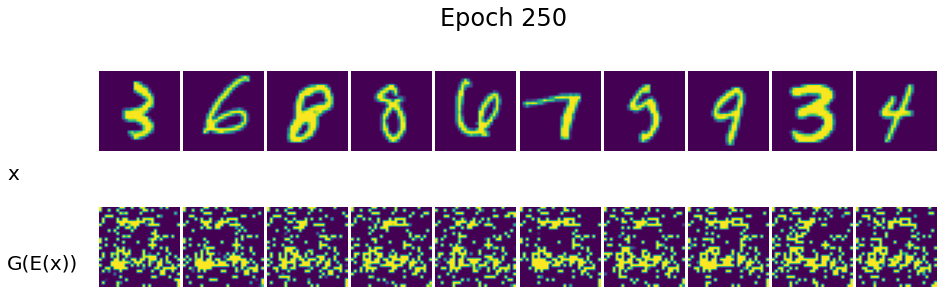

Epoch 260: 100%|██████████| 113/113 [00:01<00:00, 57.74batch/s, avg_D_loss=0.501, avg_EG_loss=4.42]


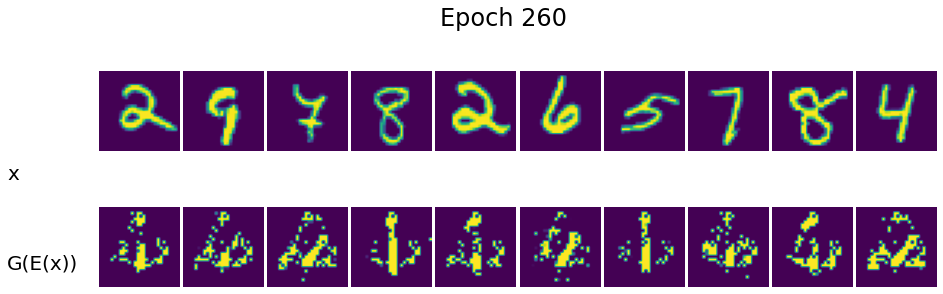

Epoch 270: 100%|██████████| 113/113 [00:02<00:00, 53.04batch/s, avg_D_loss=0.559, avg_EG_loss=3.81]


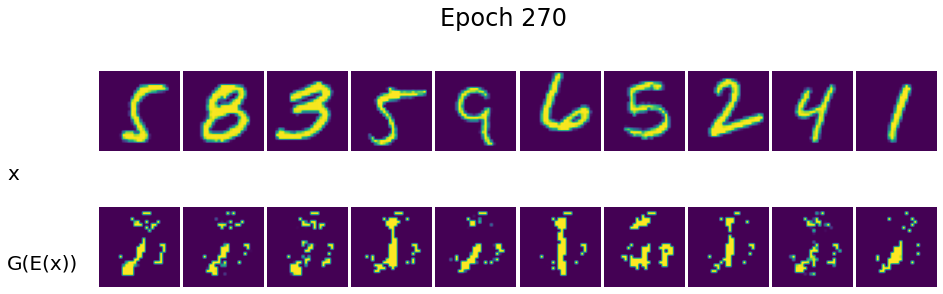

Epoch 280: 100%|██████████| 113/113 [00:02<00:00, 52.93batch/s, avg_D_loss=0.632, avg_EG_loss=3.71]


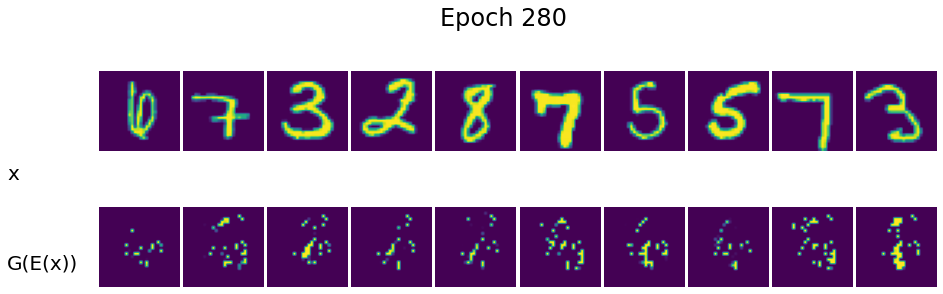

Epoch 290: 100%|██████████| 113/113 [00:01<00:00, 58.14batch/s, avg_D_loss=0.543, avg_EG_loss=3.72]


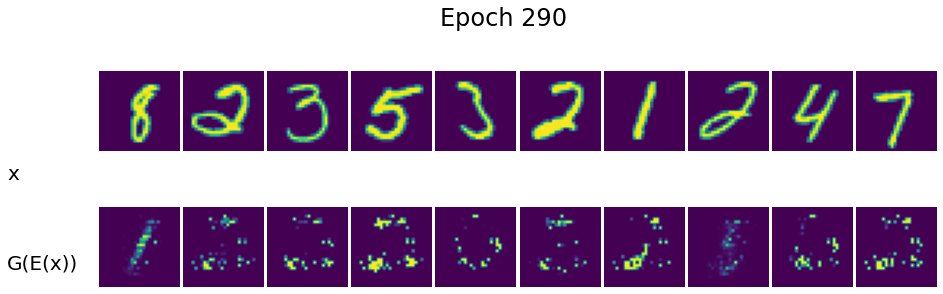

Epoch 300: 100%|██████████| 113/113 [00:02<00:00, 55.05batch/s, avg_D_loss=0.441, avg_EG_loss=4.11]


Epoch 310: 100%|██████████| 113/113 [00:02<00:00, 52.50batch/s, avg_D_loss=0.444, avg_EG_loss=4.16]


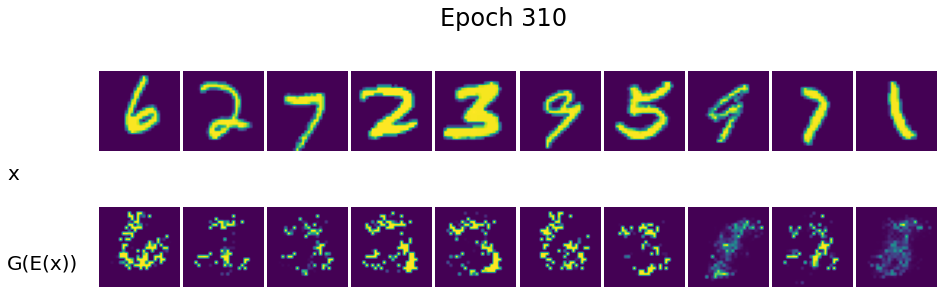

Epoch 320: 100%|██████████| 113/113 [00:02<00:00, 56.34batch/s, avg_D_loss=0.444, avg_EG_loss=4.08]


Epoch 330: 100%|██████████| 113/113 [00:02<00:00, 53.71batch/s, avg_D_loss=0.532, avg_EG_loss=3.66]


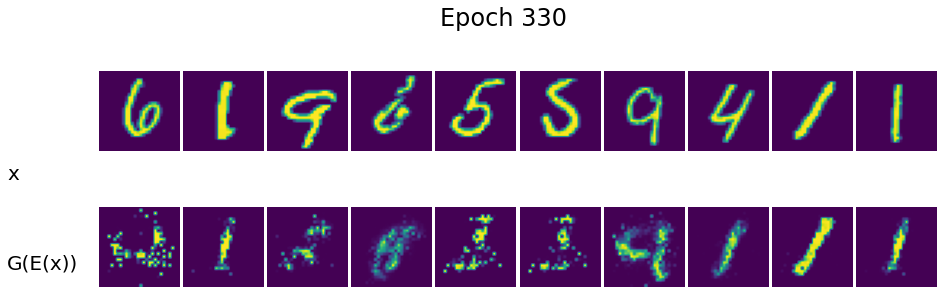

Epoch 340: 100%|██████████| 113/113 [00:02<00:00, 55.00batch/s, avg_D_loss=0.514, avg_EG_loss=3.65]


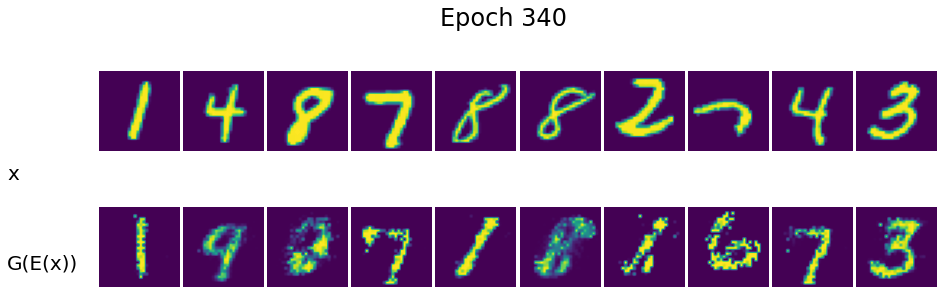

Epoch 350: 100%|██████████| 113/113 [00:01<00:00, 56.85batch/s, avg_D_loss=0.499, avg_EG_loss=3.61]


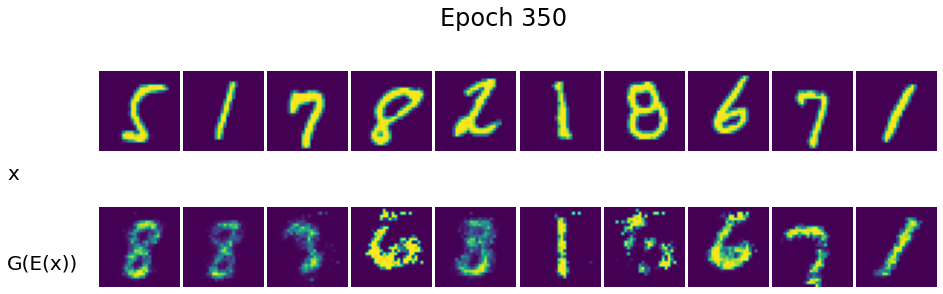

Epoch 360: 100%|██████████| 113/113 [00:02<00:00, 55.60batch/s, avg_D_loss=0.554, avg_EG_loss=3.43]


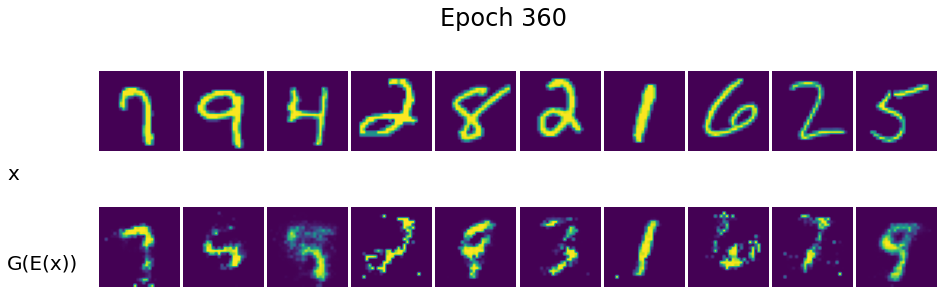

Epoch 370: 100%|██████████| 113/113 [00:02<00:00, 56.40batch/s, avg_D_loss=0.546, avg_EG_loss=3.47]


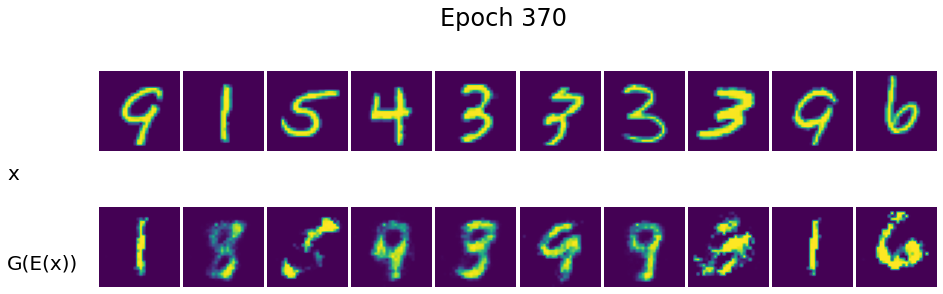

Epoch 380: 100%|██████████| 113/113 [00:02<00:00, 56.38batch/s, avg_D_loss=0.625, avg_EG_loss=3.31]


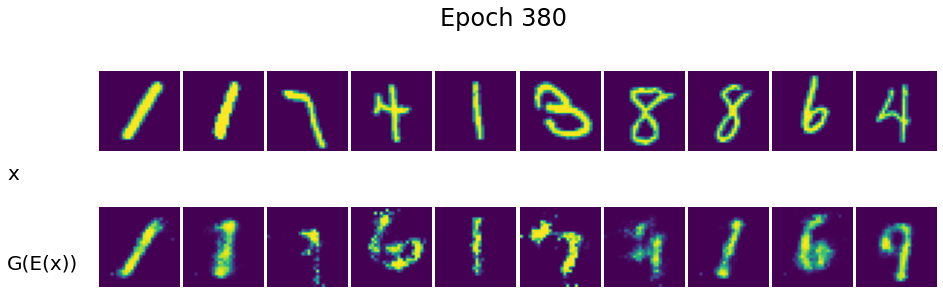

Epoch 390: 100%|██████████| 113/113 [00:01<00:00, 56.72batch/s, avg_D_loss=0.636, avg_EG_loss=3.19]


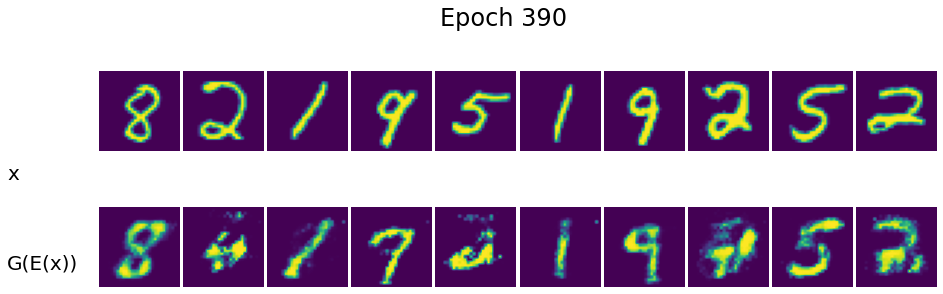

Epoch 400: 100%|██████████| 113/113 [00:02<00:00, 52.28batch/s, avg_D_loss=0.591, avg_EG_loss=3.3]


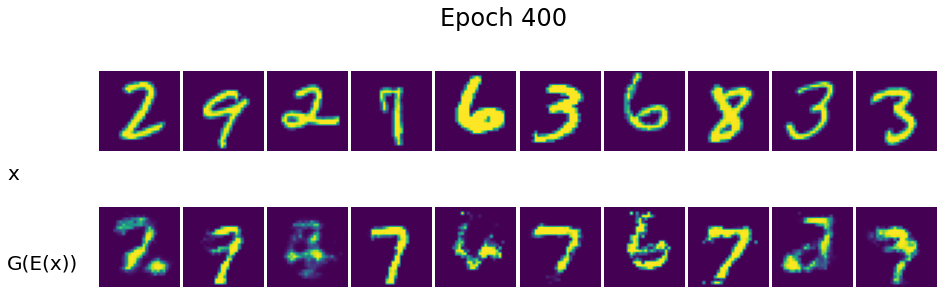

In [13]:
img_size = 28 * 28
latent_dim = 50
D_output_dim = 1

G_hyperpara = { 
    "input_dim" : latent_dim,
    "output_dim" : img_size,
    "hidden_neurons" : [1024,1024]
    }
E_hyperpara = {
    "input_dim" : img_size,
    "output_dim" : latent_dim,
    "hidden_neurons" : [1024,1024]
}
D_hyperpara = {
    "input_dim": img_size,
    "latent_dim": latent_dim,
    "hidden_neurons": [1024, 1024],
    "output_dim": D_output_dim 
}



G = Generator(**G_hyperpara).to(device)
E = Encoder(**E_hyperpara).to(device)
D = Discriminator(**D_hyperpara).to(device)

epochs = 400
batch_size = 64

E.apply(init_weights)
G.apply(init_weights)
D.apply(init_weights)

optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()),  lr=2e-5, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(),  lr=2e-5, betas=(0.5, 0.999), weight_decay=1e-5)

loss_func = nn.BCELoss()

D_losses = []
EG_losses = []




for epoch in range(epochs):
    D_loss_acc = 0
    EG_loss_acc = 0

    D.train()
    E.train()
    G.train()
    progress_bar = tqdm(train_loader, unit="batch")
    for i, (img, idx) in enumerate(progress_bar):


        img = img.to(device)
        img= img.reshape(img.size(0),-1)

        y_true = torch.ones((img.size(0), 1)).to(device)
        y_fake = torch.zeros((img.size(0), 1)).to(device)


        #initialize z from 50-dim U[-1,1]
        z = 2 * torch.rand(img.size(0), latent_dim) - 1
        z = z.to(device)


        #Discriminator training
        # G.eval()
        # E.eval()
        # D.train()

        G_z = G(z)
        E_x = E(img)
        D_G = D(G_z,z) # D(G(z),z): negative samples
        D_E = D(img,E_x) # D(x,E(x)): positive samples

        optimizer_D.zero_grad()
        
        #loss_D = loss_func(D_G, y_fake) + loss_func(D_E, y_true) # log D(x,E(x)) + log(1-D(G(z),z))
        #print(loss_D)
        loss_D = D_loss(D_G,D_E)

        
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        
        # G.train()
        # E.train()
        # D.eval()

        #Encoder & Generator training
        optimizer_EG.zero_grad()
        
        

        D_G = D(G_z,z) # D(G(z),z)
        D_E = D(img,E_x) # D(x,E(x))
        
        # loss_EG = loss_func(D_G, y_true) + loss_func(D_E, y_fake) # log D(G(z),z) + log(1-D(x,E(x)))
        loss_EG = EG_loss(D_G,D_E)
        

        loss_EG.backward()
        
        optimizer_EG.step()

        # D.train()

        D_losses.append(loss_D.item())
        EG_losses.append(loss_EG.item()) 
        D_loss_acc += loss_D.item()
        EG_loss_acc += loss_EG.item()

        progress_bar.set_description(f"Epoch {epoch+1}")
        progress_bar.set_postfix(avg_D_loss=D_loss_acc / (i+1), avg_EG_loss=EG_loss_acc / (i+1))
        # progress_bar.set_postfix(D_losses[i],EG_losses[i])
        #sleep(0.1)


    if (epoch + 1) % 10 == 0:

        D.eval()
        E.eval()
        G.eval()
        n_show = 10
        with torch.no_grad():
            
            
            real = img[:n_show]
            
            recon = G(E(real)).reshape(n_show, 28, 28).cpu().numpy()
            real = real.reshape(n_show, 28, 28).cpu().numpy()
            #print(recon[0].shape)

            fig, ax = plt.subplots(2, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            plt.rcParams.update({'font.size': 20})
            fig.suptitle('Epoch {}'.format(epoch+1))
 
            fig.text(0.04, 0.5, 'x', ha='left')
            fig.text(0.04, 0.25, 'G(E(x))', ha='left')

            for i in range(n_show):
                ax[0, i].imshow(real[i])
                ax[0, i].axis('off')
                ax[1,i].imshow(recon[i])
                ax[1,i].axis('off')
            plt.show()
     
    # if epoch % 10 == 0:
    #     print(f"Epoch: {epoch} Loss D.: {loss_D.item()}")
    #     print(f"Epoch: {epoch} Loss EG.: {loss_EG.item()}")

  



In [3]:
def func(**d):
    print(d)

func(**G_hyperpara)

{'input_dim': 50, 'output_dim': 784, 'hidden_neurons': [1024, 1024]}


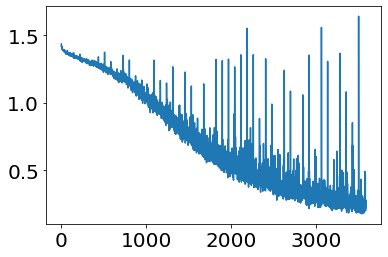

In [39]:
plt.plot(D_losses)

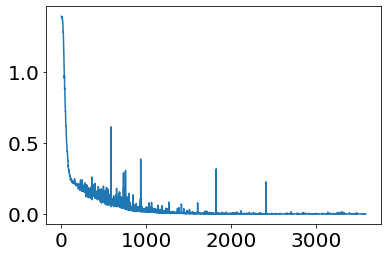

In [40]:
plt.plot(EG_losses)

In [41]:
D.eval()
E.eval()
G.eval()
CEL = nn.CrossEntropyLoss()
A_s = []
labels = []
for i, (img, idx) in enumerate(test_loader):
    img = img.to(device)
    img= img.reshape(img.size(0),-1)
    y_true = torch.ones((img.size(0), 1)).to(device)


    z_hat = E(img)
    
    x_hat = G(z_hat)
    D_E = D(img,z_hat)

    
    L_D = CEL(D_E,y_true).item()
    L_G = torch.norm(x_hat-img,p=1).item()
    A_s.append(0.5*L_D + 0.5 * L_G)
    labels.append(idx)

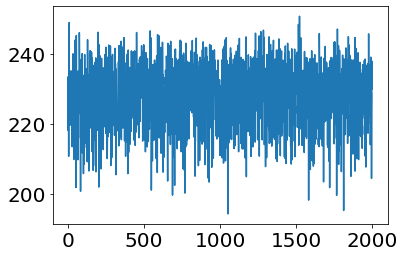

In [42]:
plt.plot(A_s)

In [46]:
def median(x):
    x = sorted(x)
    length = len(x)
    mid, rem = divmod(length, 2) 
    if rem:
        return x[:mid], x[mid + 1:], x[mid]
    else:
        return x[:mid], x[mid:], (x[mid - 1] + x[mid]) / 2

A_s = np.array(-A_s)
lHalf, rHalf, q2 = median(A_s)

res = (median(rHalf)[2]-median(lHalf)[2])*1.5 + median(rHalf)[2]
print('Abnormal score:{}'.format(res))

Abnormal score:-203.62115478515625


In [47]:
abnormal_label = np.where(A_s > res)[0]

In [48]:
len(abnormal_label)

15

In [75]:
result = [labels[i] for i in abnormal_label]

In [76]:
result

[tensor([6.]),
 tensor([6.]),
 tensor([4.]),
 tensor([0.]),
 tensor([9.]),
 tensor([4.]),
 tensor([6.]),
 tensor([6.]),
 tensor([6.]),
 tensor([6.]),
 tensor([9.]),
 tensor([2.]),
 tensor([2.]),
 tensor([3.]),
 tensor([2.]),
 tensor([4.]),
 tensor([8.]),
 tensor([8.]),
 tensor([0.]),
 tensor([0.]),
 tensor([4.]),
 tensor([0.]),
 tensor([8.]),
 tensor([2.]),
 tensor([0.]),
 tensor([0.]),
 tensor([6.]),
 tensor([0.]),
 tensor([6.])]

Train again:

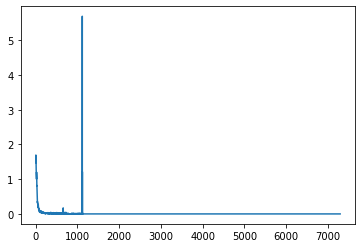

In [24]:
plt.plot(np.log(D_losses))

In [21]:
len(EG_losses)

54

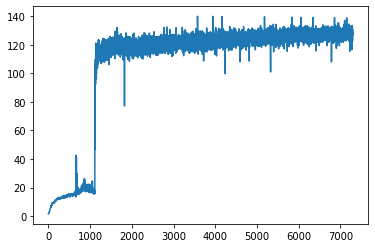

In [25]:
plt.plot(EG_losses)